- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [ ]:
# %pip install gdown
# %pip install PIL
import os
import zipfile
from PIL import Image
import gdown
from glob import glob    # glob is a module in Python used to find files and directories whose names match a specific pattern
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image_dataset_from_directory

# `+` Seed Value  *&* Set Global Parameters

In [ ]:
SEED = 907
# Set random seed for reproducibility
BATCH_SIZE = 8
EPOCHS = 15

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
# Download Lung Data from Google Drive using g down
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=681989b6-bcb9-4937-874f-e031abec8fab
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:01<00:00, 25.6MB/s]


'Lung_Data.zip'

In [ ]:
# Define the path to your zip file and extraction directory
# zip_path = "Lung_Data.zip"
# extract_to = "Lung_Data"

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("Unzipping completed.")

!unzip -q Lung_Data.zip

In [ ]:
# the images is in bmp Extension so we need to convert it to png to deal with it in matplotlib and other libraries
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(
        os.path.join(out_dir, os.path.basename(img).rsplit('.', maxsplit=1)[0] + '.png'),
        'PNG'
)

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
# Training Dataset
grey_train , grey_val  = image_dataset_from_directory(
    'Lung_Data_PNG/grey',
    batch_size=BATCH_SIZE,
    labels=None,
    color_mode='grayscale',
    image_size=(512, 512),
    seed=SEED,
    validation_split=0.15,
    subset='both',
)


Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [ ]:
# Validation Dataset
mask_train , mask_val  = image_dataset_from_directory(
    'Lung_Data_PNG/mask',
    batch_size=BATCH_SIZE,
    labels=None,
    color_mode='grayscale',
    image_size=(512, 512),
    seed=SEED,
    validation_split=0.15,
    subset='both',
)

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

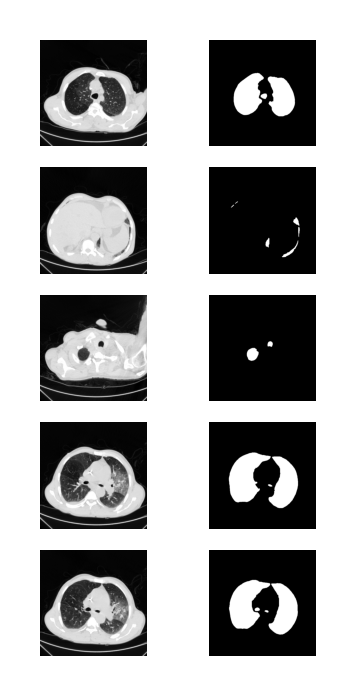

In [ ]:
# Preview Images
plt.figure(figsize=(1,2), dpi=400)
for images,masks in zip(grey_train.take(5), mask_train.take(5)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

In [ ]:
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

-------------------
 Building U-Net from Scratch

In [ ]:
def double_conv(x, n_filters):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv(x, n_filters)
    p = MaxPooling2D(2, 2)(f)
    return f, p

In [ ]:
def upsample_block(x, n_filters, skip_features):
    x = Conv2DTranspose(n_filters, (3, 3), 2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = double_conv(x, n_filters)
    return x

## `i` Model Design

In [ ]:
# Model Architecture
inputs = Input((512, 512, 1))

# Rescaling layer (Normalize the pixel values to be between 0 and 1)
x = Rescaling(1./255)(inputs)

# Encoder
f0, p0 = downsample_block(x, 32)
f1, p1 = downsample_block(p0, 64)  # Fixed the issue here
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)

# Bottleneck
b = double_conv(p3, 512)

# Decoder
d1 = upsample_block(b, 256, f3)
d2 = upsample_block(d1, 128, f2)
d3 = upsample_block(d2, 64, f1)
d4 = upsample_block(d3, 32, f0)

# Output Layer (1x1 convolution to match the input size)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

# Build and compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [ ]:
# Pairing inputs and targets: zip ensures that each input image is paired with its corresponding mask.
# Normalization: Rescaling ensures that both input and mask values are in the same range, which helps training stability.
# Efficiency: Using tf.data.Dataset ensures the data pipeline is efficient and scalable, handling data loading and preprocessing while training.

segment_train = tf.data.Dataset.zip(grey_train, mask_train.map(lambda x: Rescaling(1./255)(x)))
segment_val = tf.data.Dataset.zip(grey_val, mask_val.map(lambda x: Rescaling(1./255)(x)))

In [ ]:
history = model.fit(
    x=segment_train,
    epochs=EPOCHS,
    validation_data=segment_val,
    #  This parameter defines the number of batches of data the model should process before completing one epoch. Typically, this is set to the number of batches in your training dataset.
    steps_per_epoch=grey_train.cardinality().numpy(),
    validation_steps=grey_val.cardinality().numpy()
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7636 - loss: 0.5171 - val_accuracy: 0.8835 - val_loss: 0.4186
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 628ms/step - accuracy: 0.8933 - loss: 0.3902 - val_accuracy: 0.8081 - val_loss: 0.5076
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 644ms/step - accuracy: 0.8813 - loss: 0.3872 - val_accuracy: 0.8835 - val_loss: 0.3795
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.8947 - loss: 0.3290 - val_accuracy: 0.8835 - val_loss: 0.2067
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.8939 - loss: 0.2085 - val_accuracy: 0.8830 - val_loss: 0.3466
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 627ms/step - accuracy: 0.8903 - loss: 0.2773 - val_accuracy: 0.8835 - val_loss: 0.2306
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 630ms/step - accuracy: 0.8895 - loss: 0.3014 - val_accuracy: 0.8835 - val_loss: 0.3028
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.8903 - loss: 0.2666 - val_accurac

In [ ]:
model.save('model-unet.h5')

## `iii` Model Evaluation

In [ ]:
print("accuracy on training" , model.evaluate(segment_train)[1])
print("accuracy on validation" , model.evaluate(segment_val)[1])


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.9778 - loss: 0.0633
accuracy on training 0.9782050848007202
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9765 - loss: 0.0681
accuracy on validation 0.9780646562576294


## `iv` Result Visualization

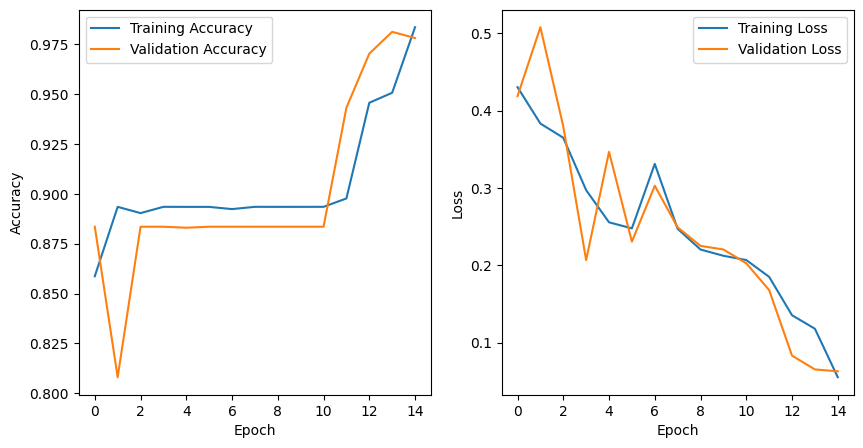

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
num_samples = 3  # Number of validation samples to visualize

# Get some validation data
sample_images = list(grey_val.take(num_samples))  # Convert the dataset to a list of images
sample_masks = list(mask_val.take(num_samples))   # Convert the dataset to a list of masks

# Extract images from the dataset (we only need the image part, not the mask)
images_batch = tf.stack([img[0] for img in sample_images])  # Stack images together into a batch
masks_batch = tf.stack([img[1] for img in sample_masks])    # Stack masks together into a batch (for reference)

# Predict the masks for these images
predicted_masks = model.predict(images_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


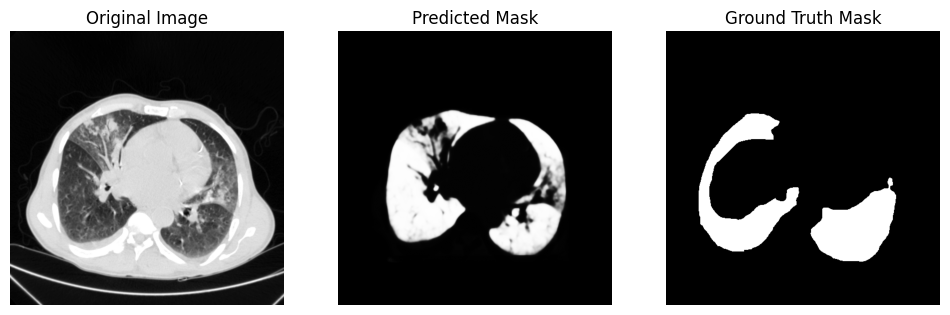

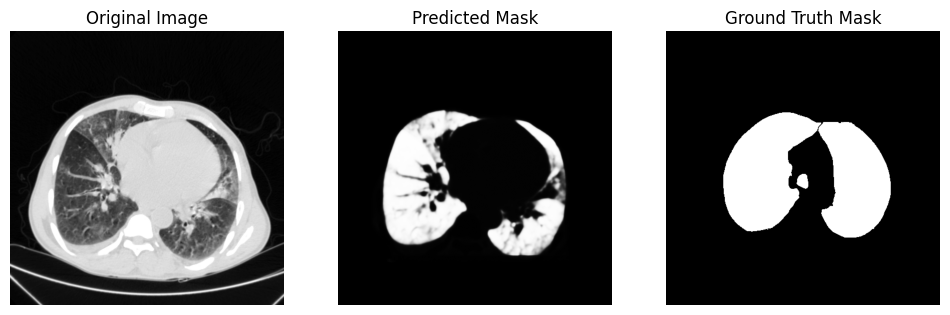

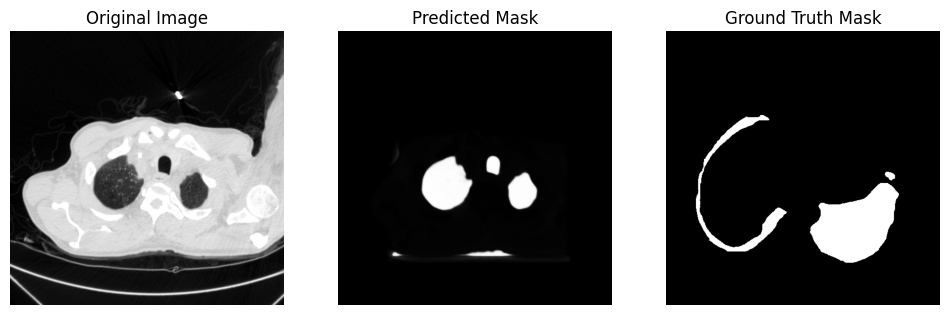

In [ ]:
# Plot the original image, predicted mask, and ground truth mask for comparison
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i][0].numpy().squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.title('Original Image')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')  # Predicted mask
    plt.title('Predicted Mask')
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks[i][1].numpy().squeeze(), cmap='gray')  # True mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.show()

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  97.5M      0  0:00:08  0:00:08 --:--:--  106M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

# zip_path = "kagglecatsanddogs_5340.zip"
# extract_to = "Lung_Data"

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("Unzipping completed.")

PetImages/Cat  PetImages/Dog


In [4]:
# Delete Corrupted Images
import os
# This script checks all images in the "Cat" and "Dog" folders of "PetImages" and deletes the ones that don’t contain the JPEG JFIF signature, assuming they're corrupted.

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [5]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input , Dense , Flatten , RandomFlip , RandomRotation
from keras.models import Model ,Sequential
from keras.applications import ResNet50
from tensorflow.keras import layers , models

## `+` Set Global Parameters

In [6]:
# Hyperparameters
SEED = 524
BATCH_SIZE  = 8
EPOCHS      = 15

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [7]:
from re import sub
# Training/Validation Dataset
train_ds , valid_ds = image_dataset_from_directory(
    'PetImages',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    seed=SEED,
    subset = 'both',
    validation_split=0.15,)

Found 23410 files belonging to 2 classes.
Using 19899 files for training.
Using 3511 files for validation.


### Preview the Images

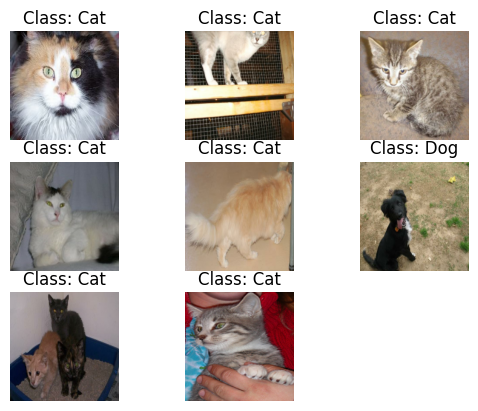

In [8]:
# Preview Images
for images, labels in train_ds.take(1):   # take the first batch
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')  #Assigns a title based on the label: If labels[i] == 0, it shows "Cat".If labels[i] == 1, it shows "Dog".
    plt.axis('off')

## Augment Data Manually

In [9]:
def manual_augment(image,label):
  #random horizontl flip
  image = tf.image.random_flip_left_right(image)
  #randomly brightness
  image = tf.image.random_brightness(image,max_delta=0.1)
  #random constrat
  image = tf.image.random_contrast(image,lower=0.9,upper=1.1)

  return image,label

In [10]:
augmented_ds = train_ds.map(manual_augment)

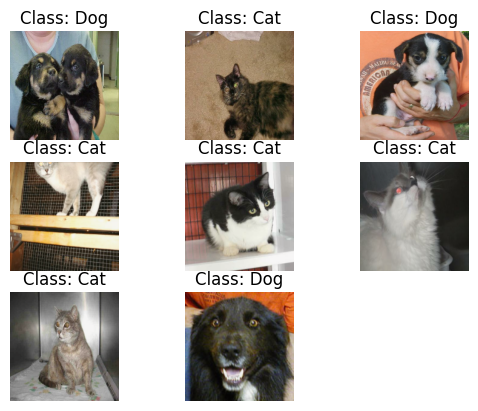

In [11]:
for images, labels in augmented_ds.take(1):   # take the first batch
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')  #Assigns a title based on the label: If labels[i] == 0, it shows "Cat".If labels[i] == 1, it shows "Dog".
    plt.axis('off')

In [12]:
# or we can make the augmentiation direct when making the model like this way
model = Sequential()
model.add(Input((180, 180, 3)))
model.add(RandomFlip())
model.add(RandomRotation(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 97200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,441,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,441,857 (47.46 MB)

 Trainable params: 12,441,857 (47.46 MB)

 Non-trainable params: 0 (0.00 B)

## perper the data for ResNet 50

In [13]:
SIZE = (224,224)
Batch_size = 32

In [14]:
train_ds , valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=SIZE,
    batch_size=BATCH_SIZE
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [15]:
# apply normalization to images making it from 0,1

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

## `i` Model Design

In [16]:
# i will use ResNet 50 as a transfer learning to this task
base_model = ResNet50(input_shape=(224,224,3),
                      include_top=False,
                      weights ="imagenet") #for none random intialization


# we should freeze the base model params
base_model.trainable = False

# Build our model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())   # so we don't need to make flatten
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## `ii` Model Compilation & Training

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    x=train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds)

Epoch 1/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 99s 36ms/step - accuracy: 0.5747 - loss: 0.6844 - val_accuracy: 0.5931 - val_loss: 0.6624
Epoch 2/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 134s 36ms/step - accuracy: 0.6260 - loss: 0.6462 - val_accuracy: 0.6350 - val_loss: 0.6313
Epoch 3/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.6369 - loss: 0.6352 - val_accuracy: 0.6185 - val_loss: 0.6468
Epoch 4/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 136s 33ms/step - accuracy: 0.6532 - loss: 0.6255 - val_accuracy: 0.6739 - val_loss: 0.6047
Epoch 5/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.6561 - loss: 0.6208 - val_accuracy: 0.6734 - val_loss: 0.6039
Epoch 6/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.6589 - loss: 0.6132 - val_accuracy: 0.6653 - val_loss: 0.6060
Epoch 7/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 87s 36ms/step - accuracy: 0.6669 - loss: 0.6066 - val_accuracy: 0.6929 - val_loss: 0.5894
Epoch 8/15
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.6759

In [20]:
model.save("Resnet50-dog-cat.h5")

## `iii` Model Evaluation

In [21]:
print("model Accuracy on training" , model.evaluate(train_ds)[1])
print("model Accuracy on testing" , model.evaluate(valid_ds)[1])

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 66s 28ms/step - accuracy: 0.7131 - loss: 0.5603
model Accuracy on training 0.7133703827857971
586/586 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7031 - loss: 0.5677
model Accuracy on testing 0.7065356969833374


## `iv` Result Visualization

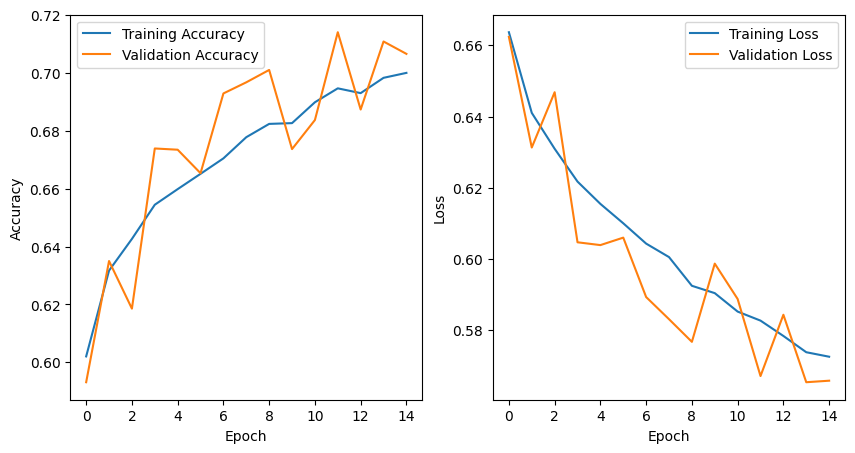

In [22]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# fine tune the model
# After a few epochs, you can unfreeze some of the base model layers to improve accuracy:

base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history = model.fit(train_ds, validation_data=valid_ds, epochs=3)

Epoch 1/3
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 347s 120ms/step - accuracy: 0.8777 - loss: 3.2792 - val_accuracy: 0.9643 - val_loss: 0.4639
Epoch 2/3
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 294s 119ms/step - accuracy: 0.9779 - loss: 0.1696 - val_accuracy: 0.9771 - val_loss: 0.2300
Epoch 3/3
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 280s 120ms/step - accuracy: 0.9878 - loss: 0.0753 - val_accuracy: 0.9731 - val_loss: 0.2749


In [24]:
model.save("Resnet50-dog-cat-after-fine-tuning.h5")

In [25]:
print("model Accuracy on training" , model.evaluate(train_ds)[1])
print("model Accuracy on testing" , model.evaluate(valid_ds)[1])

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 64s 27ms/step - accuracy: 0.9918 - loss: 0.0518
model Accuracy on training 0.9926313757896423
586/586 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9751 - loss: 0.3005
model Accuracy on testing 0.9730884432792664


## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


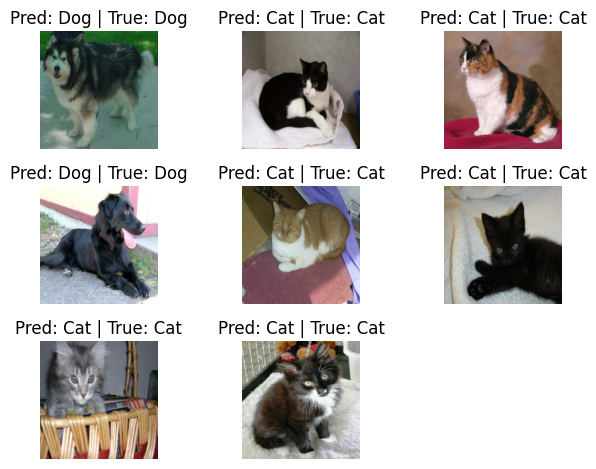

In [26]:
class_names = ['Cat', 'Dog']

# Get a batch of validation images and labels
for images, labels in valid_ds.take(1):
    preds = model.predict(images)
    preds = tf.squeeze(tf.round(preds))  # Convert probs to 0 or 1
    for i in range(8):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: {class_names[int(preds[i])]} | True: {class_names[int(labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
import requests
from PIL import Image
from io import BytesIO

def load_and_preprocess_image(url):
    # Load image from URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img = img.resize((224, 224))

    # Convert to numpy array and rescale
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


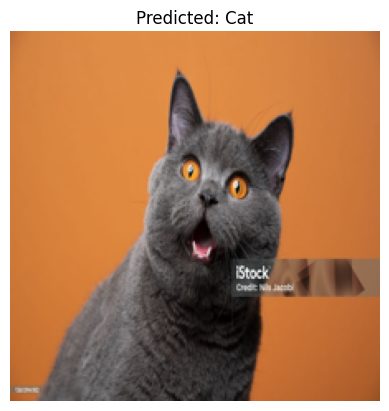

In [28]:
# Example cat image URL
img_url = "https://media.istockphoto.com/id/1361394182/photo/funny-british-shorthair-cat-portrait-looking-shocked-or-surprised.jpg?s=2048x2048&w=is&k=20&c=80OmuSCyHtOi_jqkyd4yyDjja73qPSnH3vgzRgXIIUg="
processed_img, original_img = load_and_preprocess_image(img_url)

# Make prediction
prediction = model.predict(processed_img)[0][0]
label = "Dog" if prediction > 0.5 else "Cat"

# Show result
plt.imshow(original_img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


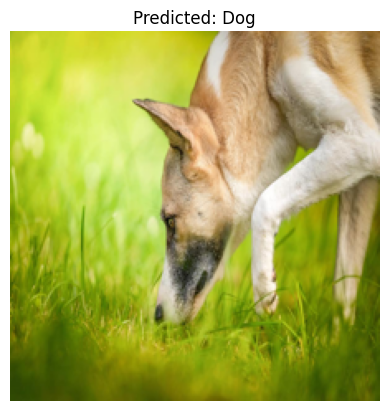

In [29]:

# Example dog image URL
img_url = "https://images.theconversation.com/files/625053/original/file-20241010-17-f9sknr.jpg?ixlib=rb-4.1.0&q=30&auto=format&w=600&h=400&fit=crop&dpr=2"

processed_img, original_img = load_and_preprocess_image(img_url)

# Make prediction
prediction = model.predict(processed_img)[0][0]
label = "Dog" if prediction > 0.5 else "Cat"

# Show result
plt.imshow(original_img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
